# Draw Confusion Matrix
draw confusion martrix from saved .pt file.  
Notice: you should change the gait_cycle, sampling, and pref_path keyword first, then run all cells.

In [1]:
# dict for title/res path pair 
# running on LELAB new 

pegasus = {
	"add":
		"/workspace/code/logs/3dcnn_attn_map_True_add/2025-06-19/08-58-07/best_preds",
	"mul":
		"/workspace/code/logs/3dcnn_attn_map_True_mul/2025-06-19/08-58-07/best_preds",
	"concat":
		"/workspace/code/logs/3dcnn_attn_map_True_concat/2025-06-19/08-58-07/best_preds",
	# "avg":
	# 	"",
	# "late":
	# 	"",
	"none":
		"/workspace/code/logs/3dcnn_attn_map_True_none/2025-06-19/08-58-07/best_preds",
}



****************************************************************************************************
pegasus, add
fold: 10
****************************************************************************************************
add
accuracy: 0.7235
precision: 0.7314
recall: 0.7235
f1_score: 0.7238
auroc: 0.8520
confusion_matrix:
[[74.98737   13.547979  11.464646 ]
 [25.289322  66.46502    8.245661 ]
 [18.225708   6.1657615 75.60853  ]]
####################################################################################################


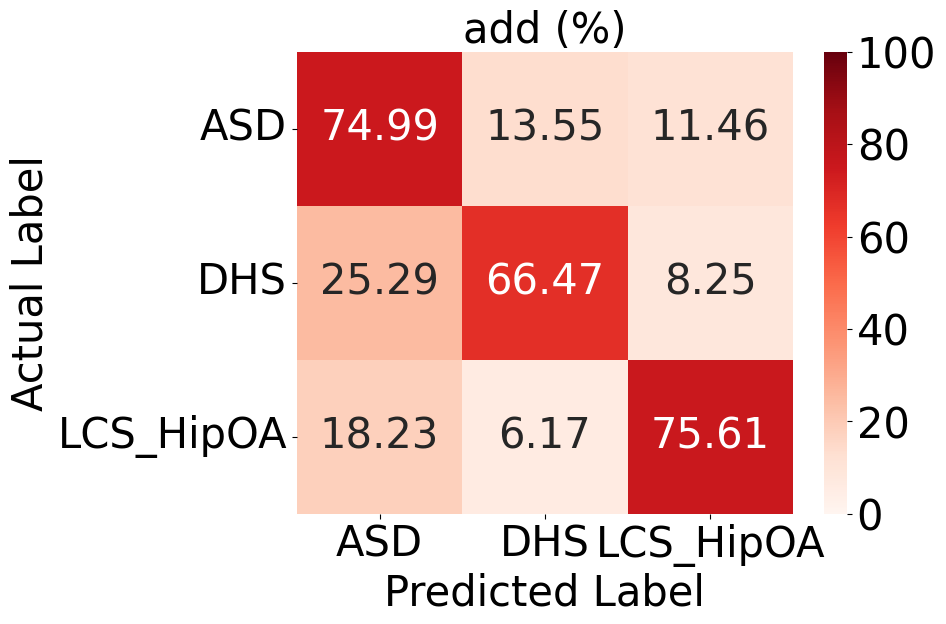

****************************************************************************************************
pegasus, mul
fold: 10
****************************************************************************************************
mul
accuracy: 0.5752
precision: 0.6662
recall: 0.5752
f1_score: 0.5762
auroc: 0.7745
confusion_matrix:
[[73.48485    4.4949493 22.0202   ]
 [49.092583  39.439766  11.4676485]
 [39.579563   0.7946087 59.625828 ]]
####################################################################################################


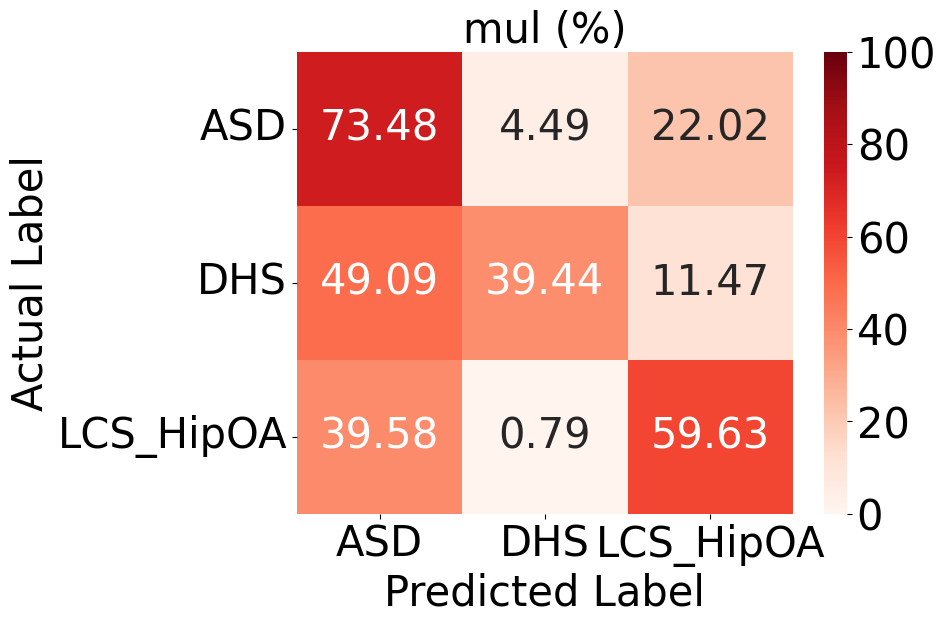

****************************************************************************************************
pegasus, concat
fold: 10
****************************************************************************************************
concat
accuracy: 0.6928
precision: 0.7260
recall: 0.6928
f1_score: 0.6757
auroc: 0.8532
confusion_matrix:
[[89.06566    4.0277777  6.906566 ]
 [26.643871  71.43608    1.920042 ]
 [38.714542  13.960974  47.324482 ]]
####################################################################################################


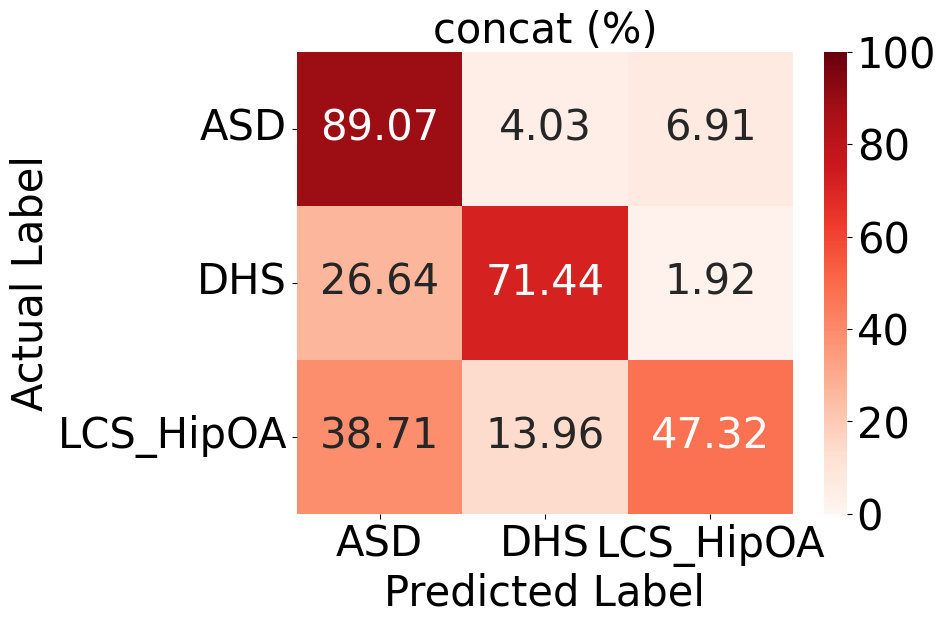

****************************************************************************************************
pegasus, none
fold: 8
****************************************************************************************************
none
accuracy: 0.6857
precision: 0.6932
recall: 0.6857
f1_score: 0.6745
auroc: 0.8390
confusion_matrix:
[[76.63424  17.562725  5.803038]
 [23.64532  66.94229   9.412386]
 [30.881235  6.986852 62.131912]]
####################################################################################################


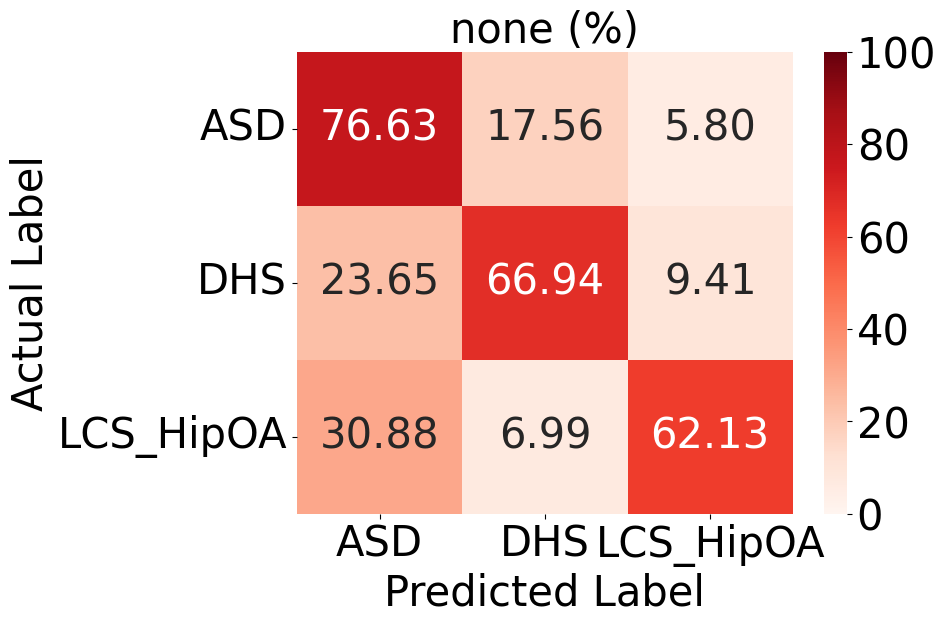

Summary of Metrics:
Model	Fold	accuracy	precision	recall	f1_score	auroc
add	10	0.7235363721847534	0.7313964366912842	0.7235363721847534	0.7237715125083923	0.8520233631134033
mul	10	0.5751681327819824	0.6662135124206543	0.5751681327819824	0.5761559009552002	0.774456799030304
concat	10	0.6927540898323059	0.7260351181030273	0.6927540898323059	0.6756653785705566	0.8532006740570068
none	8	0.6856948137283325	0.6931754350662231	0.6856948137283325	0.6745461225509644	0.8389725685119629



In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
from pathlib import Path
import pandas as pd

from torchmetrics.classification import (
MulticlassAccuracy,
MulticlassPrecision,
MulticlassRecall,
MulticlassF1Score,
MulticlassConfusionMatrix,
MulticlassAUROC,
)

# analysis with title/res path pair

def analysis_with_title_res_path_pair(pair: dict, flag: str = "with_attn_loss"):

	summary_records = []
	
	for title, res_path in pair.items():
		
		fold = 0
		print('*' * 100)
		print(f"{flag}, {title}")
		all_label = []
		all_pred = []
		
		fold = int(len(list(Path(res_path).iterdir())) / 2 )

		print(f"fold: {fold}")

		for i in range(fold):
			label = torch.load(f"{res_path}/{i}_label.pt", map_location="cpu").to(torch.int)
			pred = torch.load(f"{res_path}/{i}_pred.pt", map_location="cpu")
			all_label.append(label)
			all_pred.append(pred)

		all_label = torch.cat(all_label, dim=0)
		all_pred = torch.cat(all_pred, dim=0)
		
		print('*' * 100)
		print(title)
		confusion_matrix_data, metric_dict = metrics(all_pred, all_label, num_class=3)
		print('#' * 100)

		# save summary records
		summary_row = {"Model": title, "Fold": fold}
		summary_row.update(metric_dict)
		summary_records.append(summary_row)

		plt.rcParams.update({'font.size': 30, 'font.family': 'sans-serif'})
		axis_labels = ['ASD', 'DHS', 'LCS_HipOA']

		# draw confusion matrix
		plt.figure(figsize=(8, 6))
		sns.heatmap(confusion_matrix_data, annot=True, fmt='.2f', cmap='Reds', xticklabels=axis_labels, yticklabels=axis_labels, vmin=0, vmax=100)
		# plt.title(f'{title} (%)', fontsize=30)
		plt.title(f"{title} (%)", fontsize=30)
		plt.ylabel('Actual Label', fontsize=30)
		plt.xlabel('Predicted Label', fontsize=30)
		plt.show()
    	
	df_summary = pd.DataFrame(summary_records)
	print("Summary of Metrics:")
	print(df_summary.to_csv(sep="\t", index=False))

def metrics(all_pred: torch.Tensor, all_label: torch.Tensor, num_class: int = 3):
    # define metrics
    _accuracy = MulticlassAccuracy(num_class)
    _precision = MulticlassPrecision(num_class)
    _recall = MulticlassRecall(num_class)
    _f1_score = MulticlassF1Score(num_class)
    _auroc = MulticlassAUROC(num_class)
    _confusion_matrix = MulticlassConfusionMatrix(num_class, normalize="true")

    accuracy = _accuracy(all_pred, all_label).item()
    precision = _precision(all_pred, all_label).item()
    recall = _recall(all_pred, all_label).item()
    f1 = _f1_score(all_pred, all_label).item()
    auroc = _auroc(all_pred, all_label).item()
    cm = _confusion_matrix(all_pred, all_label).cpu().numpy() * 100

    print(f"accuracy: {accuracy:.4f}")
    print(f"precision: {precision:.4f}")
    print(f"recall: {recall:.4f}")
    print(f"f1_score: {f1:.4f}")
    print(f"auroc: {auroc:.4f}")
    print(f"confusion_matrix:\n{cm}")

    metrics_dict = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "auroc": auroc,
    }

    return cm, metrics_dict

analysis_with_title_res_path_pair(pegasus, flag="pegasus")